Content Image Shape: torch.Size([1, 3, 288, 512])
Style Image Shape: torch.Size([1, 3, 399, 512])
Epoch 0, Content Loss: 169218.984375, Style Loss: 6.68398904800415, Total Loss: 169225.671875
Epoch 50, Content Loss: 42453.21875, Style Loss: 14.949198722839355, Total Loss: 42468.16796875
Epoch 100, Content Loss: 19816.54296875, Style Loss: 18.787153244018555, Total Loss: 19835.330078125
Epoch 150, Content Loss: 12714.8525390625, Style Loss: 20.271154403686523, Total Loss: 12735.1240234375
Epoch 200, Content Loss: 9454.2109375, Style Loss: 20.941160202026367, Total Loss: 9475.15234375
Epoch 250, Content Loss: 7604.05078125, Style Loss: 21.43859100341797, Total Loss: 7625.4892578125
Epoch 300, Content Loss: 6386.943359375, Style Loss: 21.76238250732422, Total Loss: 6408.70556640625
Epoch 350, Content Loss: 5490.2060546875, Style Loss: 22.030948638916016, Total Loss: 5512.23681640625
Epoch 400, Content Loss: 4821.052734375, Style Loss: 22.303295135498047, Total Loss: 4843.35595703125
Epoch

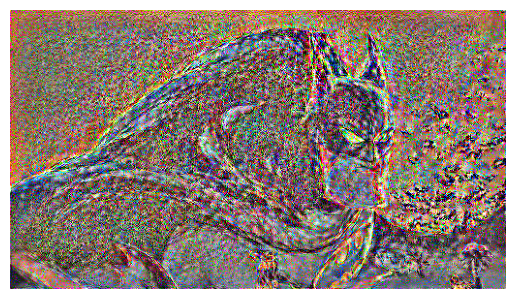

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess images
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert("RGB")
    
    # Resize image
    size = max(image.size)
    if size > max_size:
        scale = max_size / size
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    
    # Transform to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

    
    # Transform to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    """Convert a tensor to a PIL image for display."""
    image = tensor.cpu().clone().detach().numpy().squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# Load content and style images
content_image = load_image("D:/KMUTT/Year 4th/ENE490 DL/Coding/HomeWork/CNN ANN/Pic/content.jpg")
style_image = load_image("D:/KMUTT/Year 4th/ENE490 DL/Coding/HomeWork/CNN ANN/Pic/starry night.jpg")

# Define the VGG class
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = models.vgg19(pretrained=True).features[:29]
        for param in self.features.parameters():
            param.requires_grad = False

        # Correctly set the indices for layers
        self.content_layer_index = 21  # relu4_2
        self.style_layer_indices = [0, 5, 10, 19, 28]  # relu1_1 to relu5_1

    def forward(self, x):
        content_features = None
        style_features = []

        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == self.content_layer_index:
                content_features = x
            if idx in self.style_layer_indices:
                style_features.append(x)

        # Ensure the correct number of style features
        assert len(style_features) == len(self.style_layer_indices), (
            f"Expected {len(self.style_layer_indices)} style features, but got {len(style_features)}."
        )

        return content_features, style_features

print(f"Content Image Shape: {content_image.shape}")
print(f"Style Image Shape: {style_image.shape}")

# Initialize model
vgg = VGG().to(device).eval()

# Validate outputs before training
content_features, _ = vgg(content_image)
_, style_features = vgg(style_image)

# Gram matrix for style loss
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)

# Define loss and optimizer
content_weight = 1e4
style_weight = 1e3

target = torch.randn_like(content_image).requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.03)

assert content_features is not None, "Content features not computed"
assert len(style_features) == 5, "Incorrect number of style features"

# Training loop
for epoch in range(10000):
    target_content_features, target_style_features = vgg(target)
    
    assert target_content_features is not None, "Target content features are None"
    
    # Content loss
    content_loss = torch.mean((target_content_features - content_features) ** 2)
    
    # Style loss
    style_loss = 0
    for target_feature, style_feature in zip(target_style_features, style_features):
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_feature)
        style_loss += torch.mean((target_gram - style_gram) ** 2)
    
    style_loss *= style_weight
    content_loss *= content_weight
    
    # Total loss
    total_loss = content_loss + style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}, Total Loss: {total_loss.item()}")


# Display the result
output_image = im_convert(target)
plt.imshow(output_image)
plt.axis("off")
plt.show()


Content Image Shape: torch.Size([1, 3, 288, 512])
Style Image Shape: torch.Size([1, 3, 399, 512])
Epoch 50, Content Loss: 471.1859130859375, Style Loss: 2.3362252712249756, Total Loss: 473.5221252441406
Epoch 50, Content Loss: 470.8130798339844, Style Loss: 2.336252450942993, Total Loss: 473.1493225097656
Epoch 50, Content Loss: 469.185791015625, Style Loss: 2.336324453353882, Total Loss: 471.5221252441406
Epoch 50, Content Loss: 468.16473388671875, Style Loss: 2.3364176750183105, Total Loss: 470.50115966796875
Epoch 50, Content Loss: 467.4665832519531, Style Loss: 2.3364741802215576, Total Loss: 469.8030700683594
Epoch 50, Content Loss: 466.7906188964844, Style Loss: 2.336533308029175, Total Loss: 469.1271667480469
Epoch 50, Content Loss: 465.8148193359375, Style Loss: 2.3366124629974365, Total Loss: 468.15142822265625
Epoch 50, Content Loss: 465.22650146484375, Style Loss: 2.336679458618164, Total Loss: 467.56317138671875
Epoch 50, Content Loss: 464.72406005859375, Style Loss: 2.3367

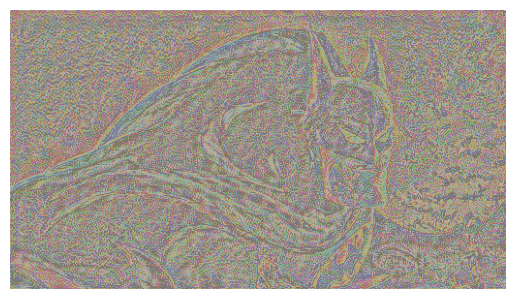

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess images
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert("RGB")
    
    # Resize image
    size = max(image.size)
    if size > max_size:
        scale = max_size / size
        size = (int(image.size[0] * scale), int(image.size[1] * scale))
        image = image.resize(size, Image.Resampling.LANCZOS)
    
    # Transform to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

    
    # Transform to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    """Convert a tensor to a PIL image for display."""
    image = tensor.cpu().clone().detach().numpy().squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# Load content and style images
content_image = load_image("D:/KMUTT/Year 4th/ENE490 DL/Coding/HomeWork/CNN ANN/Pic/content.jpg")
style_image = load_image("D:/KMUTT/Year 4th/ENE490 DL/Coding/HomeWork/CNN ANN/Pic/starry night.jpg")

# Define the VGG class
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = models.vgg19(pretrained=True).features[:29]
        for param in self.features.parameters():
            param.requires_grad = False

        # Correctly set the indices for layers
        self.content_layer_index = 21  # relu4_2
        self.style_layer_indices = [0, 5, 10, 19, 28]  # relu1_1 to relu5_1

    def forward(self, x):
        content_features = None
        style_features = []

        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == self.content_layer_index:
                content_features = x
            if idx in self.style_layer_indices:
                style_features.append(x)

        # Ensure the correct number of style features
        assert len(style_features) == len(self.style_layer_indices), (
            f"Expected {len(self.style_layer_indices)} style features, but got {len(style_features)}."
        )

        return content_features, style_features

print(f"Content Image Shape: {content_image.shape}")
print(f"Style Image Shape: {style_image.shape}")

# Initialize model
vgg = VGG().to(device).eval()

# Validate outputs before training
content_features, _ = vgg(content_image)
_, style_features = vgg(style_image)

# Gram matrix for style loss
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)

# Define loss and optimizer
content_weight = 1e2
style_weight = 1e3

target = content_image.clone().requires_grad_(True).to(device)
optimizer = optim.LBFGS([target], lr=0.005)

assert content_features is not None, "Content features not computed"
assert len(style_features) == 5, "Incorrect number of style features"

# Training loop
for epoch in range(1, 1001):  # Reduced epochs for faster convergence
    def closure():
        optimizer.zero_grad()
        target_content_features, target_style_features = vgg(target)

        # Content loss
        content_loss = torch.mean((target_content_features - content_features) ** 2)
        
        # Style loss
        style_loss = 0
        for target_feature, style_feature in zip(target_style_features, style_features):
            target_gram = gram_matrix(target_feature)
            style_gram = gram_matrix(style_feature)
            style_loss += torch.mean((target_gram - style_gram) ** 2)
        
        style_loss *= style_weight
        content_loss *= content_weight
        
        # Total loss
        total_loss = content_loss + style_loss
        total_loss.backward()

        # Print loss every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}, Total Loss: {total_loss.item()}")
        
        return total_loss

    # Perform optimizer step
    optimizer.step(closure)

    # Clamp the target image to avoid pixel overflow
    with torch.no_grad():
        target.clamp_(0, 1)

# Display the result
output_image = im_convert(target)
plt.imshow(output_image)
plt.axis("off")
plt.show()
